# ML Classifier Copies - Tutorial

<a name="Index">
    
----
# Table of contents
  
1. [**The problem**](#Problem)
2. [**Sampling strategy**](#Sampling)  
      A. [Feature space](#Feature)  
      B. [Sampler](#Sampler)  
      C. [Imbalance](#Imbalance)  
3. [**Build copy**](#Copy)  
4. [**Evaluate copy**](#Evaluation)  
      A. [Evaluation summary](#Summary)  
      B. [Class density projections](#Projections)  
    
----

In [1]:
import sys
sys.path.append("../../")

In [2]:
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from presc.dataset import Dataset
from presc.copies.copying import ClassifierCopy
from presc.copies.evaluations import multivariable_density_comparison
from presc.copies.sampling import mixed_data_features, uniform_sampling, normal_sampling, spherical_balancer_sampling, labeling

from ML_copies_original_models import OccupancyModel

[Index](#Index)  
  
  


<a name="Problem">  

-----
-----
# 1. The problem

In order to carry out the ML classifier copy, we do not need the original data nor any knowledge about the inner workings of the model, but we do need to be able to query the original model, which means that we must have access to some sort of API of the model and also have an idea of the valid ranges and input format of the sample for prediction.

In this tutorial we will use a "black box" classifier model of the publicly available [Room Occupancy Detection dataset](https://archive-beta.ics.uci.edu/ml/datasets/occupancy+detection) that we can query in order to obtain a copy, and which has been incorporated to the ML Classifier Copy package examples. But there is a variety of other "black box" classifier models incorporated with the examples that can be used to explore and practice ML classifier copying. An internet connection is necessary to load these sample models.

The task is to determine if a room is occupied or not given a series of sensor measurements (temperature, humidity, etc).

In [3]:
# Load original model
occupancy_model = OccupancyModel()

[Index](#Index)  
  
  


<a name="Sampling">  

-----
# 3. Sampling strategy

Proper sampling of the feature space is one of the **key issues** to ensure a successful copy, but it quickly becomes very challenging as the number of features increase. If we have no information on the feature distributions, it is a good idea to use a **uniform sampler**, but this may quickly become very inefficient as the number of features increase, where a **normal or a spherical sampler** may be more appropriate. But since this package is modular, more advanced samplers can be implemented by the user and connected to the other elements.

<a name="Feature">  

### Feature space

In order to sample the feature space efficiently and generate relevant synthetic data, it is important to have as much information from the features as possible. Depending on the information we can estimate from the features, we will be able to use one or another sampler.

For numerical data:
* We only have an idea of the **ranges**, ie. **minimum and maximum values** -> We can use the **uniform sampler**.
* We only have an idea of the **ranges**, but we are also able to **normalize the data** -> We can use the **uniform sampler** or the **spherical sampler**.
* We can make a rough estimation on the values on which our features are **centered** and their **standard deviation** -> We can use the **normal sampler**.

For categorical data:
* We should specify at least the **different categories** of the feature.
* If we can estimate the **frequency of each category** present in the original data, we can include that information in the feature descriptors and the sampler will generate more relevant synthetic data.
* Otherwise, an **equal probability** can be assigned for all categories.

The feature characteristics, either numerical or categorical, need to be specified in a dictionary of features. Each sampler will need a different set of feature descriptors, so not all of them need to be specified. This dictionary **can be built manually** but, if we have a sample of the original data, the feature descriptors can be extracted automatically from that into a feature dictionary. There is also a helper function to build a dictionary of categorical features with equiprobable categories.

In the case of the "black box" models, a feature dictionary has been included with the models for convenience:

In [4]:
# Feature dictionary included in the model
feature_description = occupancy_model.feature_description
feature_description

{'Temperature': {'min': 19.0,
  'max': 23.18,
  'mean': 20.61908364034549,
  'sigma': 1.0169164411058473},
 'Humidity': {'min': 16.745,
  'max': 39.1175,
  'mean': 25.731507286421873,
  'sigma': 5.531210999582151},
 'Light': {'min': 0.0,
  'max': 1546.33333333333,
  'mean': 119.5193745138974,
  'sigma': 194.7558047986205},
 'CO2': {'min': 412.75,
  'max': 2028.5,
  'mean': 606.5462431945639,
  'sigma': 314.32087688106805},
 'HumidityRatio': {'min': 0.002674126913904,
  'max': 0.0064760132367102,
  'mean': 0.003862506678320315,
  'sigma': 0.0008523312991431677}}

However, if we have a sample of the original data (these "black box" models also include it for educational purposes), we can extract the feature descriptors from there. For the category extraction to work well in a mixed dataset, the categorical columns of the dataset must be labelled as such.

In [5]:
# A sample of features of the original dataset
original_features_sample = occupancy_model.dataset.features.sample(100)
original_features_sample

,Temperature,Humidity,Light,CO2,HumidityRatio
7928,20.100,33.090,0.0,447.500000,0.004817
5243,19.290,31.000,11.5,439.000000,0.004288
4197,21.445,18.815,37.0,440.000000,0.002967
6636,19.500,26.790,0.0,480.333333,0.003751
5295,19.390,30.500,26.5,429.000000,0.004245
...,...,...,...,...,...
2940,21.000,19.890,0.0,598.000000,0.003052
7525,20.390,33.000,0.0,543.000000,0.004891
4873,19.390,31.100,0.0,440.000000,0.004329
6445,19.445,26.745,0.0,464.500000,0.003732


In [6]:
# Build the feature dictionary from a data sample
sample_feature_description = mixed_data_features(original_features_sample)
sample_feature_description

{'Temperature': {'min': 19.2,
  'max': 22.445,
  'mean': 20.53922833333333,
  'sigma': 1.0037648189767232},
 'Humidity': {'min': 17.79,
  'max': 38.8975,
  'mean': 27.029663333333332,
  'sigma': 5.544763150643499},
 'Light': {'min': 0.0,
  'max': 554.333333333333,
  'mean': 118.05333333333333,
  'sigma': 199.2683536250887},
 'CO2': {'min': 424.5,
  'max': 2012.33333333333,
  'mean': 660.3486666666666,
  'sigma': 369.42566106028903},
 'HumidityRatio': {'min': 0.0027004240849736,
  'max': 0.0064091067443912,
  'mean': 0.004043658808856615,
  'sigma': 0.000885255101010786}}

[Index](#Index)  
  
  


<a name="Sampler">  
  
    
### Sampler

There are several samplers already avaliable. These are the most common:

* **Uniform sampler:** Generates random samples where the features have a uniform distribution between the ranges specified by **min** and **max** in the provided feature dictionary. Samples generated from this sampler are unlabeled, so there's no need to provide the original classifier, but as a consequence they may be unbalanced. It is useful well when we don't have information about the feature space, but it may become too inefficient when number of features increases.
  

* **Normal sampler:** Generates random samples where each feature has individually a normal distribution with the **mean** and **sigma** specified in the provided feature dictionary. Samples generated from this sampler are unlabeled, so there's no need to provide the original classifier, but as a consequence they may be unbalanced. It is a general purpose sampler which is useful if we can at least roughly estimate the mean and standard deviation of the features.
  
  
* **Categorical sampler**: Generates random samples where the categories of each feature have the **frequency** specified at the feature dictionary. Samples generated from this sampler are unlabeled, so there's no need to provide the original classifier, but as a consequence they may be unbalanced. It is a sampler that can be used with categorical features.
  

* **Mixed data sampler**: Generates random samples for feature spaces that have a **mix of numerical and categorical features**. The feature descriptors have to be provided in a feature dictionary, and the desired numerical sampler for the numerical features has to be specified.


* **Spherical balancing sampler:** Generates random samples with a multivariate normal distribution in the joint feature space, centered at the origin and with standard deviation one (as long as radius_min and radius_max are left at their default values 0 and 1). It does not need a feature dictionary because all features are generated with a single distribution, but the number of features has to be specified. Samples generated from this sampler are labeled and balanced (generates the same number of samples for each class), hence, the original classifier has to be provided. It is a reasonably efficient balancing sampler for problems with a **large number of features**. However, it can only be used when **features have been previously standardised**.

In [7]:
# Generate three different synthetic data sets
uniform_sample = uniform_sampling(feature_description, nsamples=500)
normal_sample = normal_sampling(feature_description, nsamples=500)
spherical_sample = spherical_balancer_sampling(nsamples=500, nfeatures= 5, original_classifier=occupancy_model.model,
                                               label_col="Occupancy")

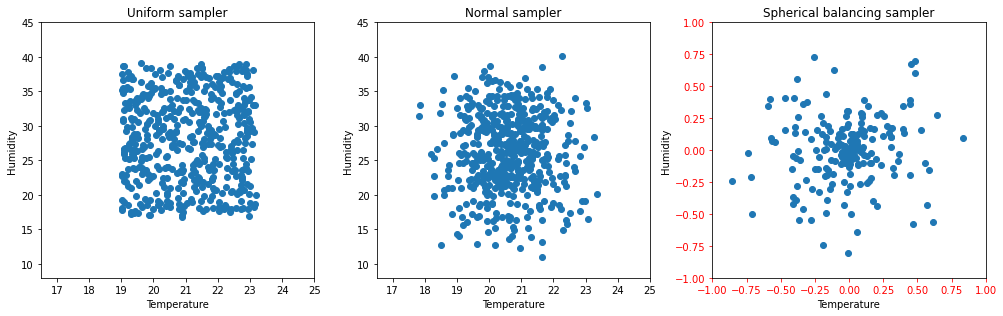

In [8]:
# Figure showing the samples generated by three different samplers
fig, axs = plt.subplots(figsize=(14, 4.5), ncols=3)
axs[0].scatter(uniform_sample["Temperature"], uniform_sample["Humidity"])
axs[1].scatter(normal_sample["Temperature"], normal_sample["Humidity"])
axs[2].scatter(spherical_sample[0], spherical_sample[1])
axs[0].set_title("Uniform sampler")
axs[1].set_title("Normal sampler")
axs[2].set_title("Spherical balancing sampler")
for i in range(3):
    axs[i].set_ylim((8,45))
    axs[i].set_xlim((16.5,25))
    axs[i].set_ylabel("Humidity")
    axs[i].set_xlabel("Temperature")
axs[2].set_ylim((-1,1))
axs[2].set_xlim((-1,1))
axs[2].tick_params(colors="red")
plt.tight_layout()
_ = plt.show

[Index](#Index)  
  
  


### Imbalanced problems

When we talk about imbalance in ML Classifier Copies we are not referring to the balance between classes provided by the original dataset, which is in principle not accessible and thus it does not have any effect in the copy. We are referring to the imbalance of the synthetic dataset used to generate the copy.

Such an imbalance arises from a combination of the particular **topology of the class boundaries** learned by the original classifier and the **sampling strategy** to perform the copy. For instance, when using samplers that probe the space uniformly, the probability of having a class in the synthetic dataset is proportional to the volume of the space defined by its boundaries. Or when using a spherical sampler that assumes a gaussian distribution of the features, the probability of having a class in the synthetic dataset might increase for those classes that are located closer to the origin with respect to those in the outskirts, even if they occupy a similar volume.

In order to tackle this problem, we can check for balance in the generated dataset, and then generate more samples if necessary until all classes have the same number of samples. In order to do this, we can simply set the parameter `enforce_balance` of the `ClassifierCopy` instance to `True`, or use a sampler that already does the balancing such as the spherical sampler.

However, this process is not efficient and may require a much longer time to generate the synthetic dataset in cases of extreme imbalance.

[Index](#Index)  
  
  


<a name="Copy">  

-----
# 4. Build copy

Since the classifier copy problem is always separable, we can in theory always obtain a perfect copy, as long as the chosen copy model family has enough complexity and that we generate enough samples to explore the relevant areas of the feature space. Generating more samples can produce a more accurate copy but only when the copy model has enough complexity. If this is not the case, the copy will eventually stop improving its performance regardless of the number of samples.

The same way it is not possible to know in advance which will be the most appropriate model for a particular problem without knowing the data. It is also difficult to decide which will be the most appropriate copy model family without knowing anything about the original classifier. Hence, this is normally a trial and error process that iterates toward the best copy model family through evaluation of the copies.

However, it is often a good idea to normalize the input data as many models require it in order to optimize properly. Therefore, we build a copy classifier pipeline that includes a standardisation preprocessing step.

In [9]:
# Instantiate copy classifier pipeline
copy_classifier = Pipeline([('scaler', StandardScaler()), ('log_classifier', LogisticRegression())])

Once we have decided the sampling strategy and the copy model or pipeline, we can instantiate the ClassifierCopy class, which allows to conveniently handle the whole copying process. Here we need to specify:
* original classifier model
* sampler that we want to use
* number of synthetic samples that we want to generate
* dictionary with the feature descriptors
* desired name for the label column

In [10]:
# Instantiate the copying process using the ClassifierCopy class
copy_class = ClassifierCopy(occupancy_model.model, copy_classifier, normal_sampling, enforce_balance=False, nsamples=2000, 
                            random_state=42, feature_parameters=feature_description, label_col="Occupancy")

And then we carry out the copy.

In [11]:
# Carrying out the copy
copy_training_data = copy_class.copy_classifier(get_training_data=True)

Copying the original classifier returns the generated synthetic data used to train the copy model, which then can be stored if needed for later use.

[Index](#Index)  
  
  


<a name="Evaluation">  

-----
# 5. Evaluate copy    

The following evaluations allow us to analyze the performance of the copy, and the adequacy of the chosen copy model family as well as the rest of the other parameters, in order to make the necessary adjustments to finally obtain a good copy.

<a name="Summary"> 

### Evaluation summary

In order to evaluate and understand the performance of the classifier copy we can use the evaluation summary, which provides the accuracy, the empirical fidelity error, and the replacement capability of the copy. Depending on our goal for the copy, the evaluation focus has to be in one or the other. 

Ideally, we want to use both **original test data** and **synthetic generated data** for the evaluation of the copy but, if this is not available, we can still use synthetic test data to compute the main performance of those magnitudes. The "black box" models also include for convenience a set of original test data so, in this case, we can use both.

A more detailed explanation of the meaning of each evaluation metric can be found in the [documentation](https://mozilla.github.io/PRESC/ml_copies.html#evaluation-of-the-copy).

In [12]:
# Generate synthetic test data
synthetic_test_data = copy_class.generate_synthetic_data(nsamples=2000, random_state=43)

# Evaluate the copy with both generated syntetic data and original test data
copy_evaluation = copy_class.evaluation_summary(test_data=Dataset(occupancy_model.X_test.join(occupancy_model.y_test), 
                                                                  label_col="Occupancy"), synthetic_data=synthetic_test_data)

Original Model Accuracy (test)          0.9920
Copy Model Accuracy (test)              0.9806
Empirical Fidelity Error (synthetic)    0.0980
Empirical Fidelity Error (test)         0.0209
Replacement Capability (synthetic)      0.9020
Replacement Capability (test)           0.9884


[Index](#Index)  
  
  


<a name="Projections">  


### Class density projections

Apart from the quantitative performance, we can also analyze and evaluate the copy using visualization tools. However, since most realistic problems have usually many more than two features, **visualizing the decision boundary** of the original model to compare it to the copy model is normally **not possible**.

Nonetheless, it is possible to sample the feature space described by the original and copy models and project the **density of the feature space occupied by each class** in feature pairs. Dissimilarity between the class density projections of the original classifier and those of the classifier copies is an indication of poor fidelity.

The data points for the visualization of the original classifier and copies topologies must be sampled homogeneously throughout the feature space to avoid introducing spurious shapes in the projected density distributions. Hence, **uniform_sampling** is a good option to carry out this sampling. 

Here we have chosen a couple of example parameters at a time and displayed their class densities side by side for the original and copy classifiers. All data used for these visualizations has been generated synthetically.

In [13]:
# Sample a number of data points in the feature space
visualization_data = uniform_sampling(nsamples=50000, feature_parameters=feature_description)

# Label sampled points with the different classifiers
visualization_original = labeling(visualization_data, occupancy_model.model, label_col="Occupancy")
visualization_copy = labeling(visualization_data, copy_class.copy, label_col="Occupancy")

In [14]:
# Common parameters for the comparisons (including the Occupancy class colors)
titles = ["Original Classifier", "Logistic Regression Classifier Copy"]
datasets = [visualization_original.df, visualization_copy.df]
other_kwargs = {"palette": {0:"red", 1:"royalblue"}}

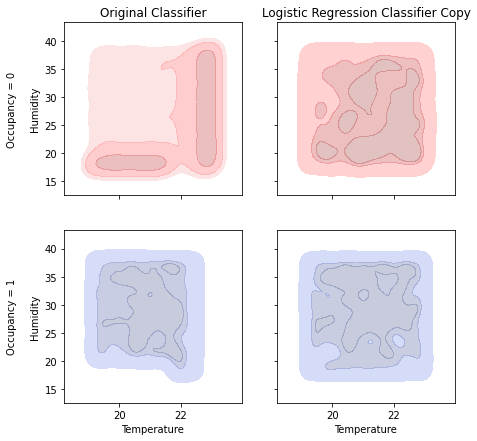

In [15]:
%%capture --no-display
fig, axs = multivariable_density_comparison(datasets=datasets, feature1="Temperature", feature2="Humidity", label_col="Occupancy",
                                            titles=titles, other_kwargs=other_kwargs)

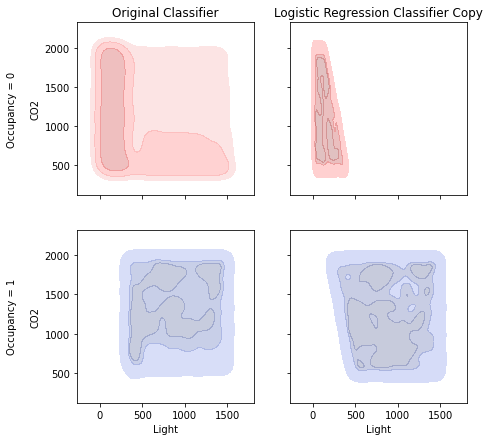

In [16]:
%%capture --no-display
fig, axs = multivariable_density_comparison(datasets=datasets, feature1="Light", feature2="CO2",  label_col="Occupancy",
                                            titles=titles, other_kwargs=other_kwargs)

[Index](#Index)  
  
  

-----
-----